# Exploratory Data Analysis - MIMIC-IV Dataset in PostgreSQL

The notebook has been implemented using Python 3.10.11.  
The MIMIC-IV v2.2 dataset has been loaded into PostgreSQL server running PostgreSQL 15.2 (Ubuntu 15.2-1.pgdg22.04+1).  
We suggest creating a virtual environment for this notebook.  
You need to install the following packages to run this notebook:

| Package Name | License                                                                                                                 | Documentation                           |
|--------------|-------------------------------------------------------------------------------------------------------------------------|-----------------------------------------|
| psycopg2     | [![License: LGPL v3](https://img.shields.io/badge/License-LGPL_v3-blue.svg)](https://www.gnu.org/licenses/lgpl-3.0)     | [Docs](https://www.psycopg.org/)        |
| pandas       | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://pandas.pydata.org/)      |
| numpy        | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://numpy.org/)              |
| seaborn      | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://seaborn.pydata.org/)     |
| scipy        | [![License](https://img.shields.io/badge/License-BSD_3--Clause-blue.svg)](https://opensource.org/licenses/BSD-3-Clause) | [Docs](https://scipy.org/)              |
| tomli        | [![License: MIT](https://img.shields.io/badge/License-MIT-blue.svg)](https://opensource.org/licenses/MIT)               | [Docs](https://github.com/hukkin/tomli) |
| tqdm         | [![License](https://img.shields.io/pypi/l/tqdm.svg)](https://github.com/tqdm/tqdm/blob/master/LICENCE)                  | [Docs](https://tqdm.github.io/)         |
| matplotlib   | [(BSD-compatible, PSF-based)](https://matplotlib.org/stable/users/project/license.html)                                 | [Docs](https://matplotlib.org/)         |


In [15]:
"""Update pip and install requirements."""
%pip install --upgrade pip
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.
  Using cached numpy-1.23.0-cp310-cp310-win_amd64.whl (14.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Zugriff verweigert: 'C:\\Users\\Claas\\Repos\\kp2\\kp-medizinische-informatik-ss23\\.venv\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Check the permissions.



In [1]:
"""Relevant imports for EDA; setup and styling."""

# data manipulation
import numpy as np
import pandas as pd

# data vizualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.gridspec import GridSpec

# tqdm for progress bars
from tqdm import tqdm

# default styling for plots
plt.style.use("ggplot")  # gnuplot style
rcParams["figure.figsize"] = 12, 6  # figure size
from matplotlib.colors import ListedColormap

# hls colormap for sns styled pie charts using matplotlib
hls = ListedColormap(sns.color_palette("hls").as_hex())


  

In [2]:
"""Functions for database connection, query execution, dataframe plotting."""

import tomli as toml
import psycopg2 as pg
from typing import Any


def read_config(path: str) -> dict:
    """Read config file and return config dict."""
    with open(path, "rb") as f:
        config = toml.load(f)["database"]
    return config


def connect_to_db(config: dict) -> Any:
    """Connect to database and return connection object."""
    conn = pg.connect(**config)
    cur = conn.cursor()
    return conn, cur


def read_sql(path: str) -> str:
    """Read SQL file and returns string"""
    with open(path, "r") as f:
        sql = f.read()
    return sql


def sql_to_df(path: str, params: dict = None) -> pd.DataFrame:
    """Read SQL file, execute query and return pandas DataFrame.
    
    Optionally, pass parameters to query using the params dict.
    """
    if params is None:
        params = {}
    conn, cur = connect_to_db(read_config("./config.toml"))
    cur.execute(read_sql(path), params)
    df = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
    conn.close()
    return df


def plot_corr_matrix(
    df: pd.DataFrame,
    method: str = "pearson",
    title: str="",
    figsize=(10, 5),
    linewidth=0.3,
    fmt=".2f",
    annot_kws={"size": 10},
    cmap="Spectral_r",
    cbar=True,
    ax=None,
    cbar_kws={"shrink": 0.8},
) -> None:
    """Plot heatmap of correlation matrix."""
    # set figure size
    if ax is None:
        plt.subplots(figsize=figsize)
    corr = df.corr(method)
    sns.heatmap(
        corr,
        cbar=cbar,  # show color bar? yes/no
        annot=True,  # show numbers in cells? yes/no
        square=True,  # square cells? yes/no
        linewidths=linewidth,  # linewidth between cells
        fmt=fmt,  # precision
        annot_kws=annot_kws,  # size of numbers in cells
        yticklabels=df.columns,  # y-axis labels
        xticklabels=df.columns,  # x-axis labels
        cmap=cmap,  # color palette
        ax=ax,  # axes object
        cbar_kws=cbar_kws,  # shrink color bar
    )
    if title:
        plt.title(title)
    if ax is None:
        plt.show()


def plot_boxplot_grid(df: pd.DataFrame, target: str) -> None:
    """Plot boxplots of multiple columns against a single target variable."""
    # calculate number of rows and columns
    n_cols = int(np.ceil(np.sqrt(len(df.columns) - 1)))
    n_rows = int(np.ceil((len(df.columns) - 1) / n_cols))
    # create figure and axes
    fig, axes = plt.subplots(
        nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 5)
    )
    # iterate over columns, rows and create boxplots
    for col, ax in zip(df.columns.drop(target), axes.flatten()):
        sns.boxplot(x=target, y=col, data=df, ax=ax)
        # set title to column name vs. target
        ax.set_title(f"{col} vs. {target}")
    plt.show()


def plot_corr_matrix_diff(
    df_one: pd.DataFrame,
    df_two: pd.DataFrame,
    method: str = "pearson",
    figsize=(10, 5),
    cmap="vlag",
    title="",
    ax=None,
) -> None:
    """Plot heatmap of difference of correlation matrices."""
    # calculate difference of correlation matrices
    corr_diff = df_one.corr(method) - df_two.corr(method)
    # plot heatmap
    plt.subplots(figsize=figsize)
    # draw arrows in cells according to correlation difference?
    sns.heatmap(
        corr_diff,
        annot=True,
        annot_kws={"size": 10},
        cbar=True,
        cmap=cmap,
        fmt=".2f",
        square=True,
        center=0,
        ax=ax,
    )
    plt.title(title)
    if ax is None:
        plt.show()


def plot_pie_chart(df, col="race", title="", ax=None, cmap=hls, explode=.1):
    """Plot pie chart for a given column in a dataframe."""
    explode = [explode] * len(df[col].value_counts())
    df[col].value_counts().plot.pie(
        shadow=True,
        autopct="%1.1f%%",
        startangle=90,
        title=title,
        cmap=cmap,
        ax=ax,
        labeldistance=1.1,
        pctdistance=0.5,
        explode=explode,
    )
    if ax is None:
        plt.show()

In [3]:
variables = sql_to_df("./sql/variables_filtered.sql")
variables_unfiltered = sql_to_df("./sql/variables.sql")

In [ ]:
from collections import defaultdict
d = defaultdict(int)
columns = variables.columns
for i, row in variables.iterrows():
    counter = 0
    for c in columns:
        x = pd.isnull(row[c])
        if isinstance(x, bool):
            if x:
                counter = counter + 1
        else:
            if x.any():
                counter = counter + 1
    d[counter] += 1

print(d)

In [ ]:
dict(sorted(d.items(), key=lambda x: x[0]))

In [ ]:
set = variables.fillna(-1) # this removes all rows currently xD we need to fill those
print(set)

trainingsset = set.drop(["sepsis"], axis=1)
labels = set["sepsis"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(trainingsset, labels, test_size=0.11, random_state=44, stratify=labels)



set_u = variables_unfiltered.fillna(-1) # this removes all rows currently xD we need to fill those

trainingsset_u = set_u.drop(["sepsis"], axis=1)
labels_u = set_u["sepsis"]
from sklearn.model_selection import train_test_split
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(trainingsset_u, labels_u, test_size=0.11, random_state=44, stratify=labels)



In [ ]:
import threading
# import the regressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


rdmForest = RandomForestClassifier(random_state = 44) 
dcsTree = DecisionTreeRegressor(random_state = 44) 
regressor = LogisticRegression(random_state = 44) 
gBoost = GradientBoostingClassifier(random_state = 44) 


def forestThread():
    # create a regressor object
    rdmForest.fit(X_train, y_train)
def dcsTreeThread():
    dcsTree.fit(X_train, y_train)
def gBoostThread():
    gBoost.fit(X_train, y_train)
def regressorThread():
    regressor.fit(X_train, y_train)



rdmForest_u = RandomForestClassifier(random_state = 44) 
dcsTree_u = DecisionTreeRegressor(random_state = 44) 
regressor_u = LogisticRegression(random_state = 44) 
gBoost_u = GradientBoostingClassifier(random_state = 44) 



def forestThread_u():
    # create a regressor object
    rdmForest_u.fit(X_train_u, y_train_u)
def dcsTreeThread_u():
    dcsTree_u.fit(X_train_u, y_train_u)
def gBoostThread_u():
    gBoost_u.fit(X_train_u, y_train_u)
def regressorThread_u():
    regressor_u.fit(X_train_u, y_train_u)

x1 = threading.Thread(target=forestThread)
x2 = threading.Thread(target=dcsTreeThread)
x3 = threading.Thread(target=gBoostThread)
x4 = threading.Thread(target=regressorThread)
x5 = threading.Thread(target=forestThread_u)
x6 = threading.Thread(target=dcsTreeThread_u)
x7 = threading.Thread(target=gBoostThread_u)
x8 = threading.Thread(target=regressorThread_u)
x1.start()
x2.start()
x3.start()
x4.start()
x5.start()
x6.start()
x7.start()
x8.start()

x1.join()
x2.join()
x3.join()
x4.join()

x5.join()
x6.join()
x7.join()
x8.join()







In [ ]:

y_pred_forest = rdmForest.predict(X_test)
y_pred_dcsTree = dcsTree.predict(X_test)
y_pred_gBoost = gBoost.predict(X_test)
y_pred_regressor = regressor.predict(X_test)


y_pred_forest_u = rdmForest_u.predict(X_test_u)
y_pred_dcsTree_u = dcsTree_u.predict(X_test_u)
y_pred_gBoost_u = gBoost_u.predict(X_test_u)
y_pred_regressor_u = regressor_u.predict(X_test_u)


In [ ]:
from sklearn.metrics import matthews_corrcoef
forest_mcc = matthews_corrcoef(y_test, y_pred_forest)
dcsTree_mcc = matthews_corrcoef(y_test, y_pred_dcsTree)
gBoost_mcc = matthews_corrcoef(y_test, y_pred_gBoost)
regressor_mcc = matthews_corrcoef(y_test, y_pred_regressor)


from sklearn.metrics import roc_auc_score
forest_roc = roc_auc_score(y_test, y_pred_forest)
dcsTree_roc = roc_auc_score(y_test, y_pred_dcsTree)
gBoost_roc = roc_auc_score(y_test, y_pred_gBoost)
regressor_roc = roc_auc_score(y_test, y_pred_regressor)

forest_mcc_u = matthews_corrcoef(y_test, y_pred_forest_u)
dcsTree_mcc_u = matthews_corrcoef(y_test, y_pred_dcsTree_u)
gBoost_mcc_u = matthews_corrcoef(y_test, y_pred_gBoost_u)
regressor_mcc_u = matthews_corrcoef(y_test, y_pred_regressor_u)

forest_roc_u = roc_auc_score(y_test, y_pred_forest_u)
dcsTree_roc_u = roc_auc_score(y_test, y_pred_dcsTree_u)
gBoost_roc_u = roc_auc_score(y_test, y_pred_gBoost_u)
regressor_roc_u = roc_auc_score(y_test, y_pred_regressor_u)



In [ ]:
data = [[forest_mcc, forest_roc, forest_mcc_u, forest_roc_u], [dcsTree_mcc, dcsTree_roc, dcsTree_mcc_u, dcsTree_roc_u], [gBoost_mcc, gBoost_roc, gBoost_mcc_u, gBoost_roc_u], [regressor_mcc, regressor_roc, regressor_mcc_u, regressor_roc_u]]
df = pd.DataFrame(data, columns=["MCC", "ROC", "MCC unfiltered", "ROC unfiltered"], index=["RandomForestClassifier", "DecisionTreeRegressor", "GradientBoostingClassifier", "LogisticRegression"])
print(df)

### Can the presence/absence of values predict sepsis? (Null Value Analysis)

In [3]:
variables = sql_to_df("./sql/variables_filtered.sql")

# Drop stay_id and subject_id columns, since they are not needed for the analysis
if "stay_id" in variables.columns and "subject_id" in variables.columns:
    variables.drop(["stay_id", "subject_id"], axis=1, inplace=True)

Average percentage of null values per row where sepsis == 1:  33.056346434197266
Average percentage of null values per row where sepsis == 0:  30.68004448576768


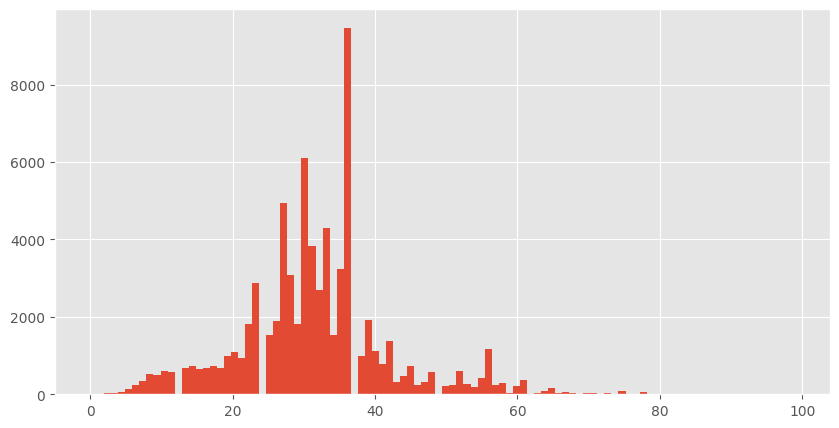

In [4]:
# How many null values are there per row?
# And how do these null values correlate with sepsis? First, let's look at the null values per row.
# Maybe there is a clear pattern, e.g. all rows with sepsis == 1 have a lot of null values or vice versa.

# Count number of null values per row
null_counts = variables.isnull().sum(axis=1)
# Divide by number of columns to get percentage of null values per row
null_counts = (null_counts / variables.shape[1]) * 100

# Plot histogram of null values per row
null_counts.hist(bins=100, figsize=(10, 5))

# Add null_counts as new column to df
variables["null_counts"] = null_counts

# Print average percentage of null values per row, split by sepsis
# (Should roughly equal 33% for sepsis==1 and 30% for sepsis==0)
print("Average percentage of null values per row where sepsis == 1: ", variables[variables["sepsis"] == 1]["null_counts"].mean())
print("Average percentage of null values per row where sepsis == 0: ", variables[variables["sepsis"] == 0]["null_counts"].mean())

# Drop null_counts column again
if "null_counts" in variables.columns:
    variables.drop("null_counts", axis=1, inplace=True)

# Coarse grained view is inconclusive, let's look at a finer grained view...

<Axes: title={'center': 'Percentage of null values per variable (Sepsis - Not Sepsis)'}>

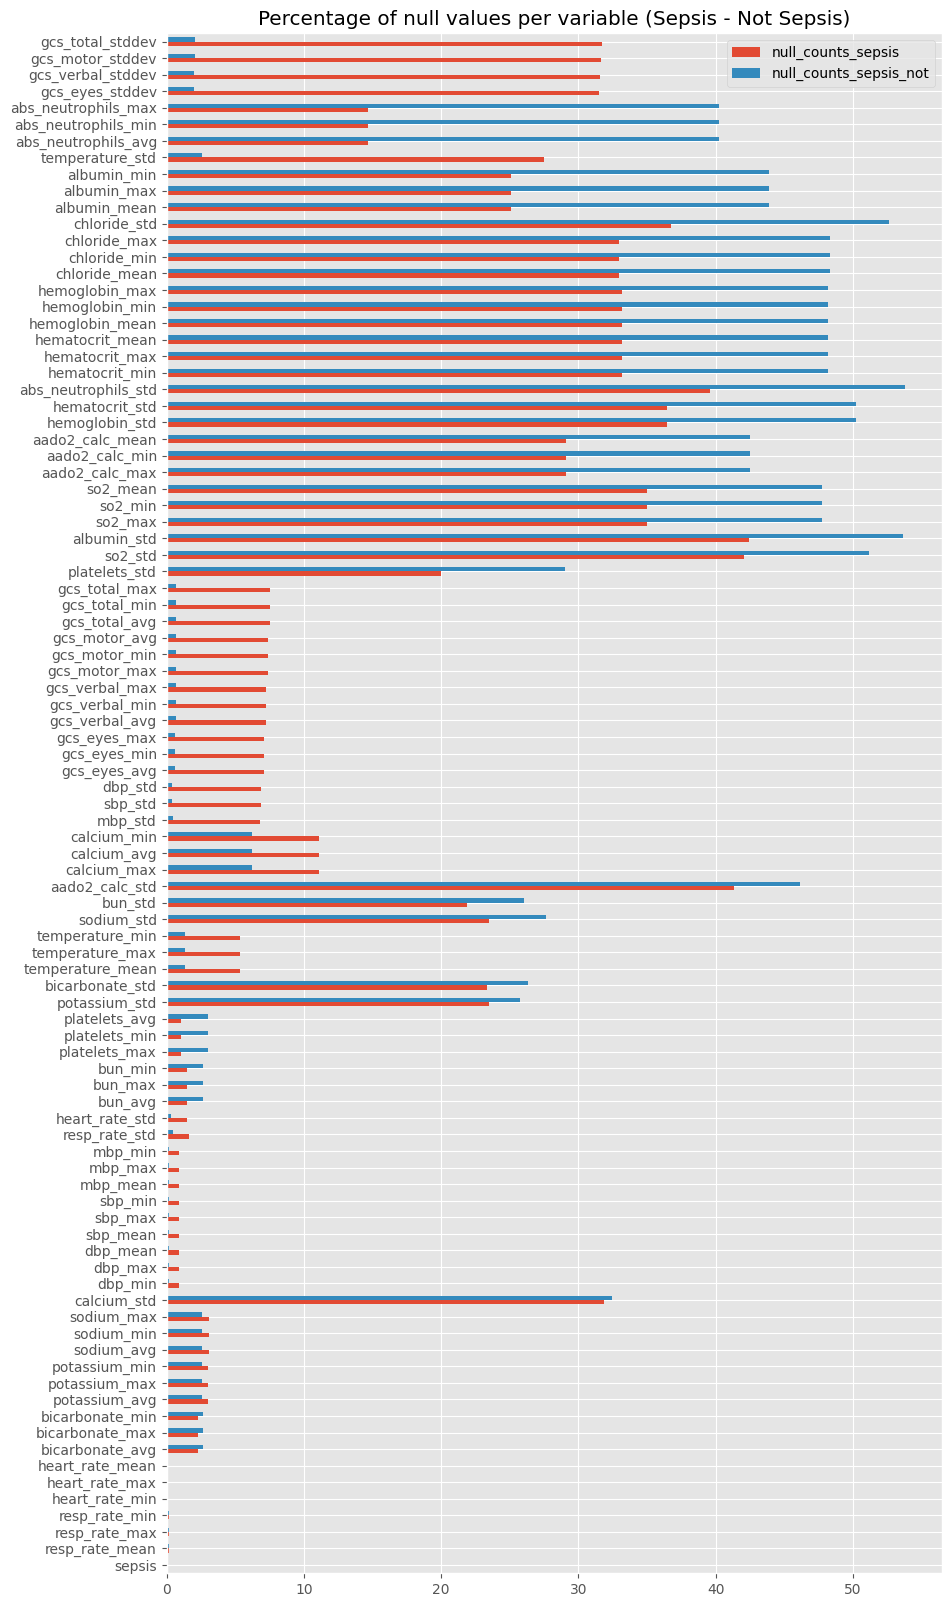

In [5]:
# What about the distribution of null values per column, i.e. the distribution of null values for each variable?
# Maybe the average number of null values per row is roughly the same, but the distribution of null values per column could be different.
# This could mean that the model would still be able to learn a shortcut, e.g. "if variable x is null, then sepsis == 1".

# Count number of null values per column, i.e. per variable
null_counts_sepsis = variables[variables["sepsis"] == 1].isnull().sum(axis=0).to_frame(name="null_counts")
null_counts_sepsis_not = variables[variables["sepsis"] == 0].isnull().sum(axis=0).to_frame(name="null_counts")

# Divide by number of rows to get percentage of null values per column, i.e. per variable
# (We use the number of overall rows to obtain the percentage of null values per column, not the number of rows where sepsis == 1 or sepsis == 0)
null_counts_sepsis = (null_counts_sepsis / variables.shape[0]) * 100
null_counts_sepsis_not = (null_counts_sepsis_not / variables.shape[0]) * 100

# Join null_counts_sepsis and null_counts_sepsis_not to plot them in one plot
null_counts_sepsis = null_counts_sepsis.join(null_counts_sepsis_not, lsuffix="_sepsis", rsuffix="_sepsis_not")
# Plot bar chart of null values per column, sort by difference in null values
null_counts_sepsis["diff"] = abs(null_counts_sepsis["null_counts_sepsis"] - null_counts_sepsis["null_counts_sepsis_not"])
# Do not display difference in bar chart, but sort by difference
null_counts_sepsis.sort_values(by="diff", ascending=True).drop("diff", axis=1).plot.barh(figsize=(10, 20), title="Percentage of null values per variable (Sepsis - Not Sepsis)")

# Indeed, there are some variables where the difference in null values is quite large.
# For example, patients that develop a sepsis have a lot more null values for the variable "abs_neutrophils_avg" than patients that do not develop a sepsis.
# Let's try to calculate the correlation between the presence of a variable and the sepsis target.

<Axes: title={'center': 'Correlation of (presence encoded) variables with sepsis'}>

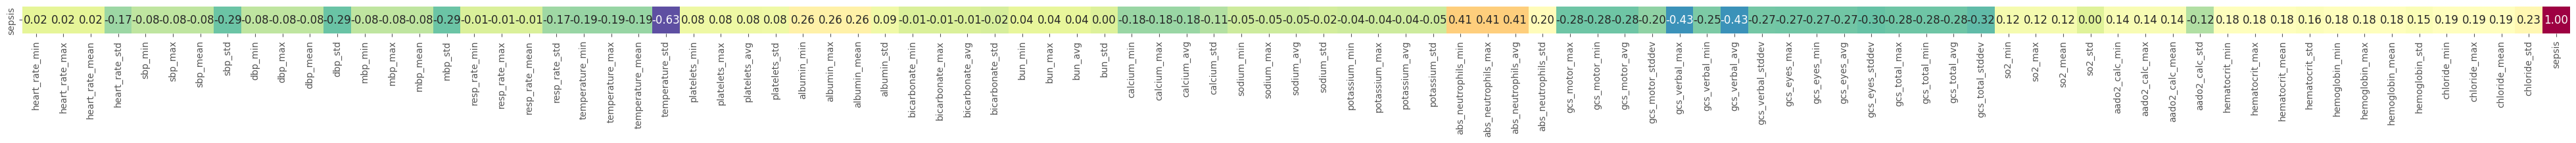

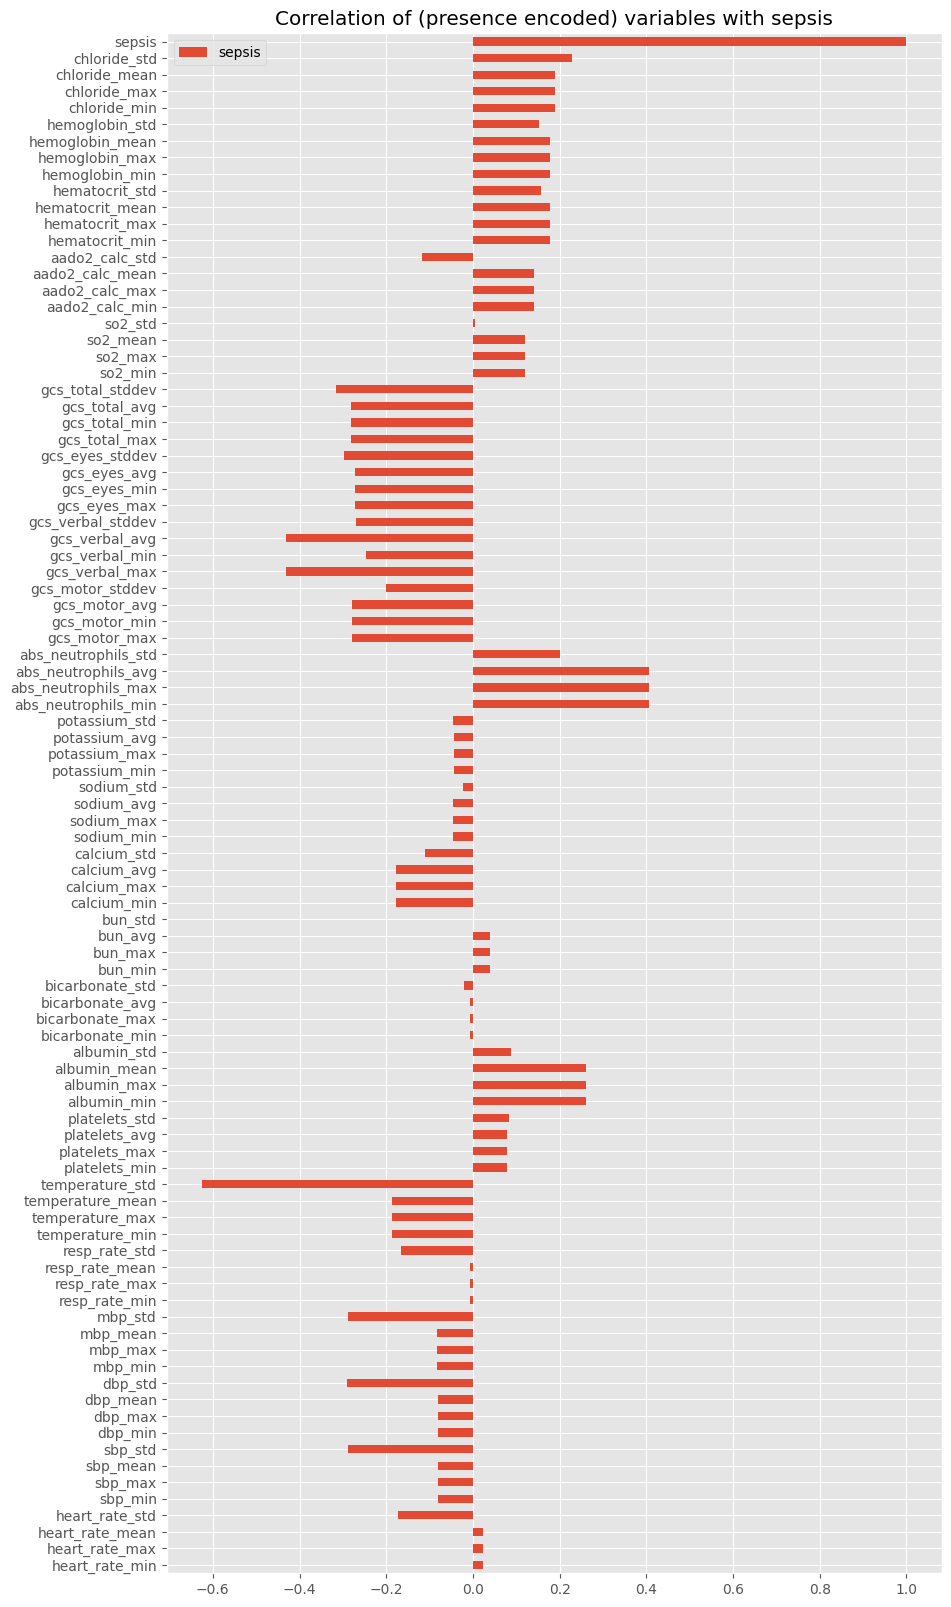

In [29]:
# To plot the correlation matrix, we need to replace the null values with some other value to encode the absence of a variable.
# Likewise, we need to replace all values != 0 with some other value to encode the presence of a variable.
# Let's use 0 for the absence of a variable and 1 for the presence of a variable.

# Replace all null values with 0 (encodes the absence of a variable)
absent = variables.fillna(0)
# Replace all values != 0 with 1 (encodes the presence of a variable)
# Cast to bool first to convert all values != 0 to True, then cast to int to convert True to 1
present = absent.astype(bool).astype(int)

# Display sepsis as the last column to make it easier to see correlations with the target variable
cols = list(present.columns)
present = present[[col for col in cols if col != "sepsis"] + ["sepsis"]]

# plot_corr_matrix(present, title="Correlation matrix of variables", figsize=(50, 50))

# The correlation matrix is a bit hard to read, let's extract only the correlations with the sepsis target.
corr = present.corr(method="pearson")
# Drop all rows except the sepsis row
corr = corr.drop([col for col in corr.columns if col != "sepsis"])

# Let's plot only the correlations with the sepsis target.
# Still as a heatmap, because it's easier to see the correlations.
plt.subplots(figsize=(50, 5))
sns.heatmap(corr, annot=True, annot_kws={"size": 12}, cbar=False, cmap="Spectral_r", fmt=".2f", square=True)

# Let's plot the correlations with the sepsis target as a bar chart.
corr.T.plot.barh(figsize=(10, 20), title="Correlation of (presence encoded) variables with sepsis")

# This indicates that the simple presence of a variable is apparently a good indicator. This can be good or bad...
# It could mean that the model is able to learn a shortcut, e.g. "if variable x is present, then sepsis == 1".
# Or it could mean that the model is able to learn a causal relationship, e.g. some measurements are done less frequently for certain patients due to reasons we don't know.
# For example, maybe the variable "abs_neutrophils_avg" is only measured for patients that are already suspected to have a sepsis. (Although this is just a guess...)
# It is more likely that the model is able to learn a shortcut, because the correlations are quite high. (e.g. -0.63 for "temperature_std", 0.41 for "abs_neutrophils_avg")

# Note that negative correlations mean that the presence of a variable is negatively correlated with the sepsis target, i.e. the absence of a variable is positively correlated with the sepsis target.
# I.e. the absence of a variable is a good indicator for sepsis.
# Likewise, positive correlations mean that the presence of a variable is positively correlated with the sepsis target, i.e. the presence of a variable is a good indicator for sepsis.

In [18]:
# Based on the above, let's try to train a model simply using the presence of a variable as a feature.
# Let's use a gradient boosting classifier using the XGBoost library.

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import matthews_corrcoef

# Convert types to float64
present = present.astype("float64")
# Split into features and target
X, y = present.drop("sepsis", axis=1), present[["sepsis"]]

# Split into train and test set
# Use 20% of the data for testing, use a fixed random state to make results reproducible
# Use stratify=y to ensure that the train and test set have the same ratio of sepsis==1 and sepsis==0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# Create regressor matrices
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Grid search for hyperparameter tuning
param_grid = {
    "max_depth": [5, 6, 10],
    "learning_rate": [0.1, 0.01],
    "subsample": [0.5, 0.7],
}

# Create a classifier using the binary:logistic objective and the gpu_hist tree method
xgb_model = xgb.XGBClassifier(objective="binary:logistic", tree_method="gpu_hist")
# Use grid search to find the best hyperparameters, use 5-fold (stratified) cross validation, use MCC as scoring metric
# Use verbose=5 to display progress, use n_jobs=-1 to use all available CPU cores
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='matthews_corrcoef', verbose=5, n_jobs=10)
grid_search.fit(X_train, y_train)

print("Best params: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


# Test the model on the test set
y_pred = grid_search.predict(X_test)
# Calculate the Matthews correlation coefficient
print("MCC: ", matthews_corrcoef(y_test, y_pred))

# MCC of 0.77 is laughably good using only the presence of a variable as a feature.
# Let's investigate the feature importance to see which variables are most important.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params:  {'learning_rate': 0.1, 'max_depth': 6, 'subsample': 0.5}
Best score:  0.7701823071672333
MCC:  0.7759048265877025


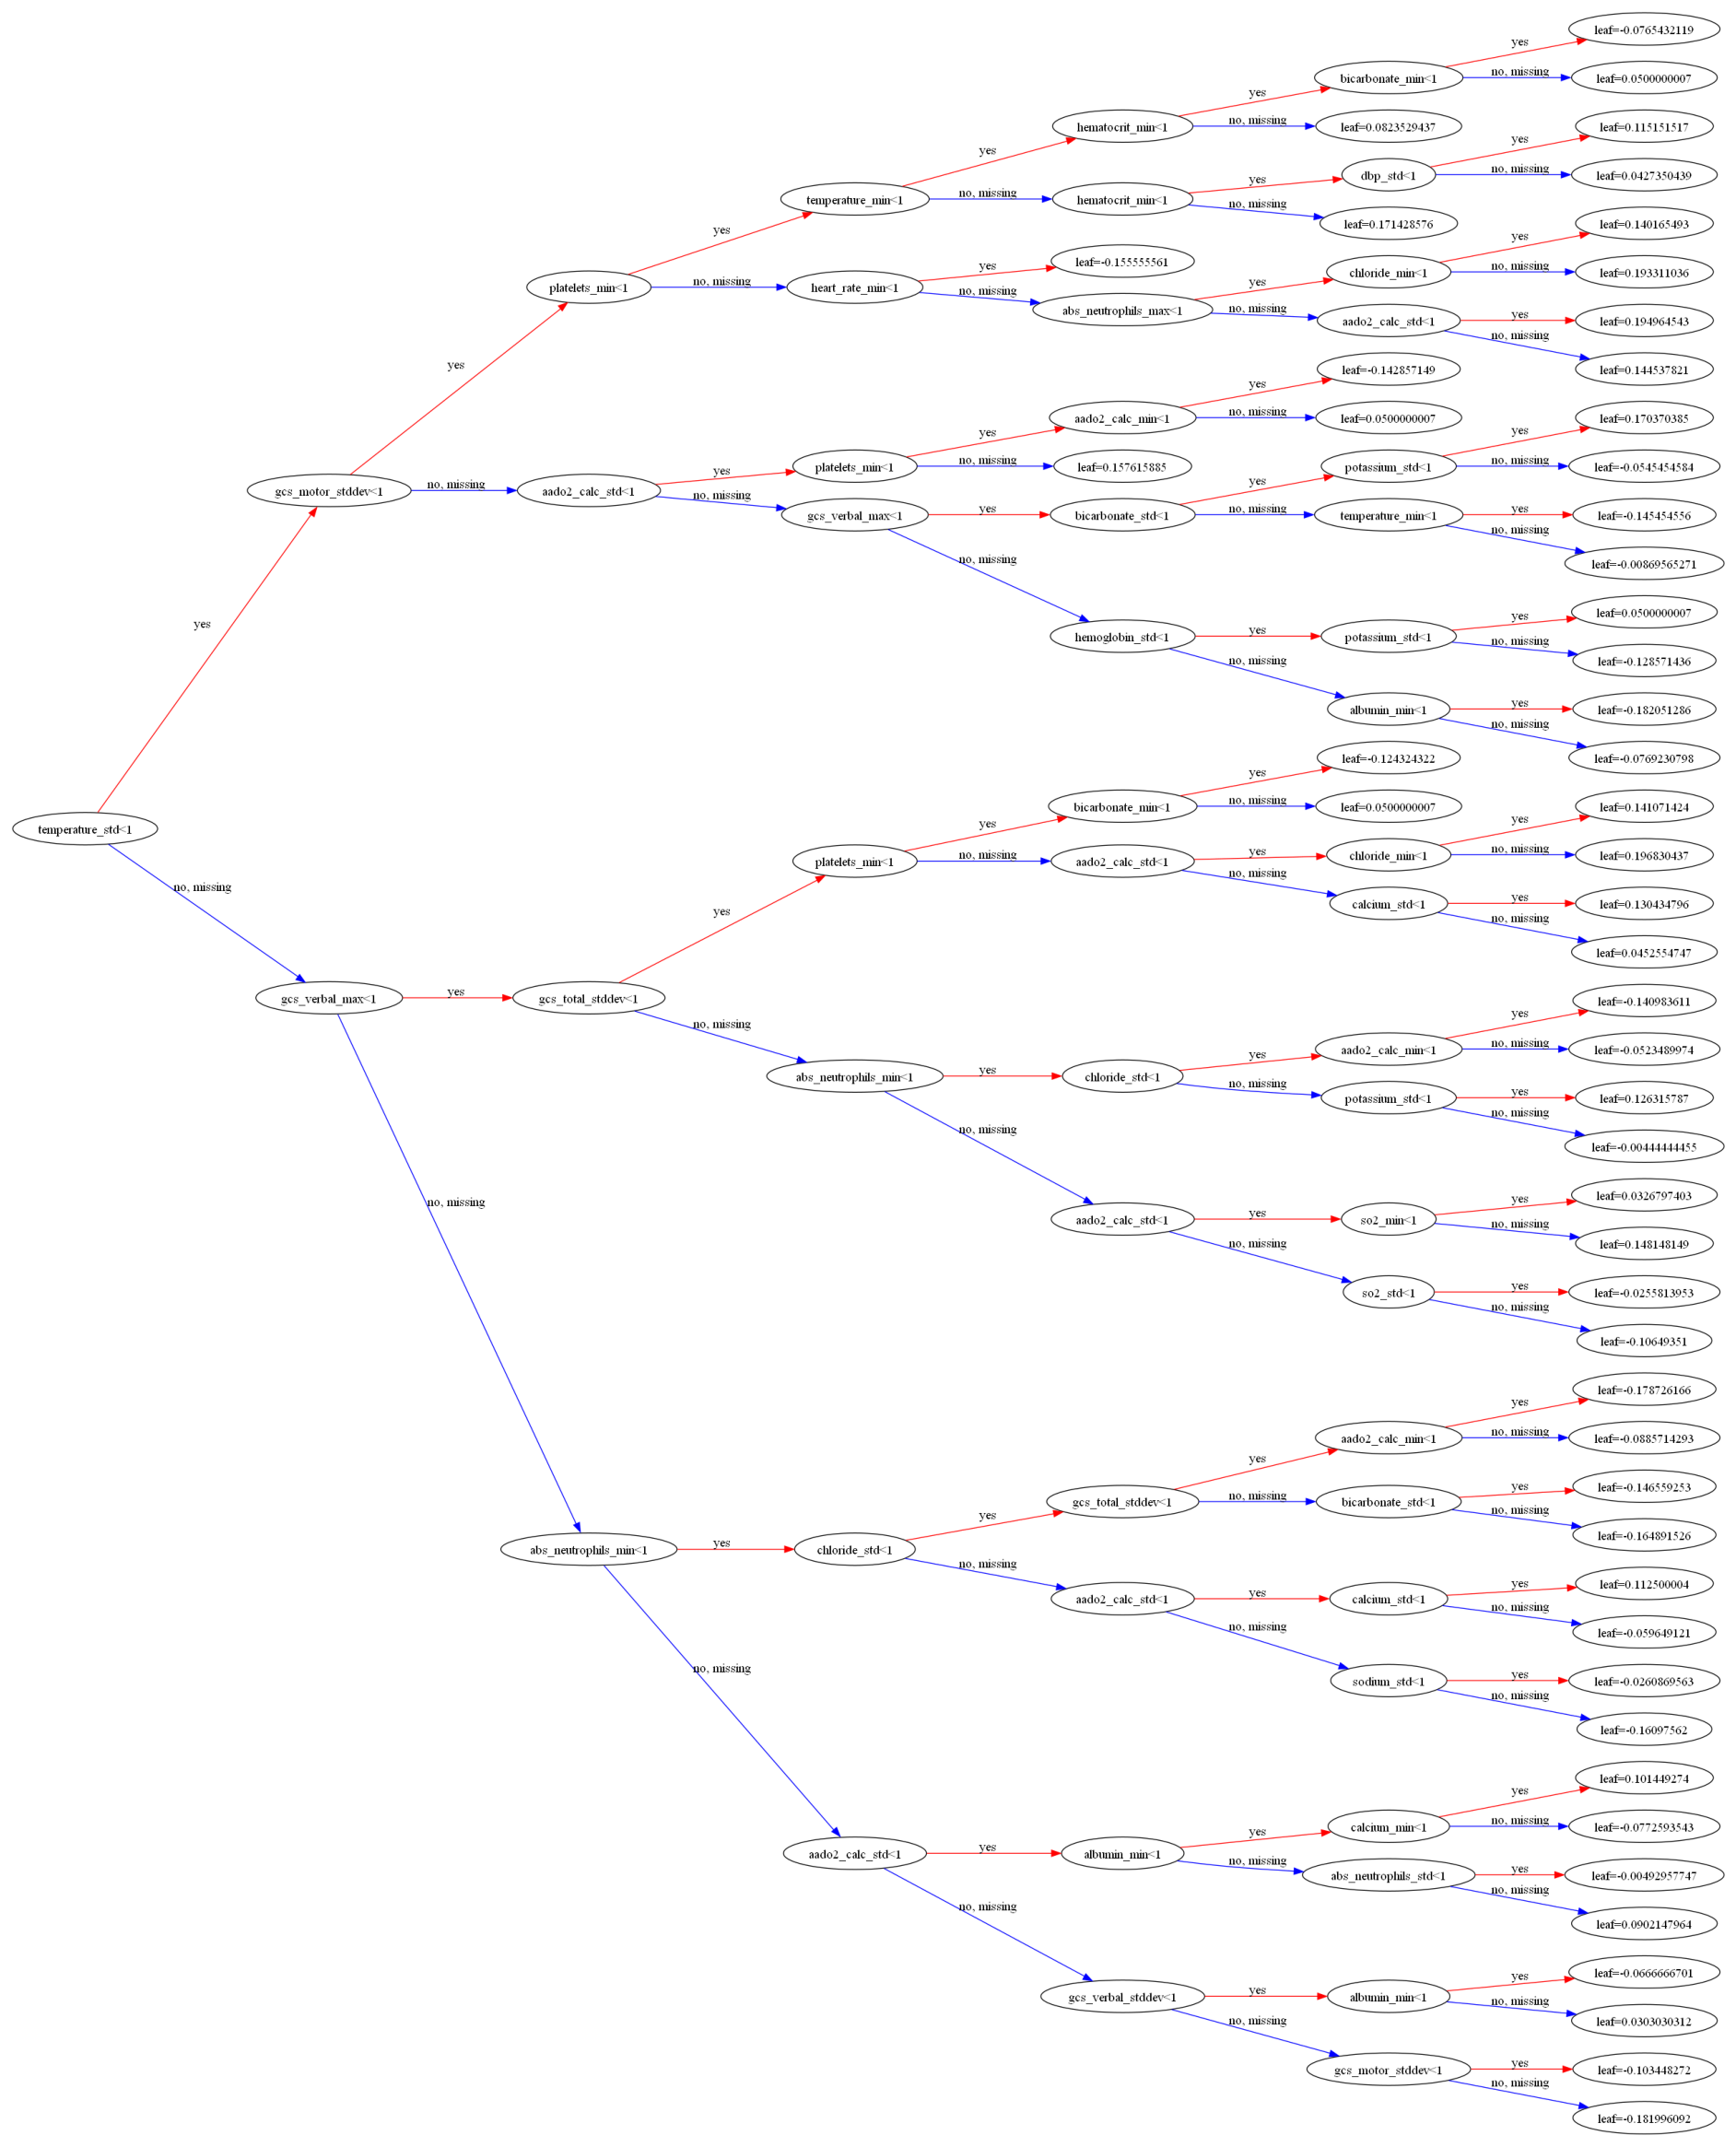

In [9]:
# Let's take a look at the learned tree.
fig, ax = plt.subplots(figsize=(30, 30))
xgb.plot_tree(grid_search.best_estimator_, ax=ax, rankdir="LR")
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


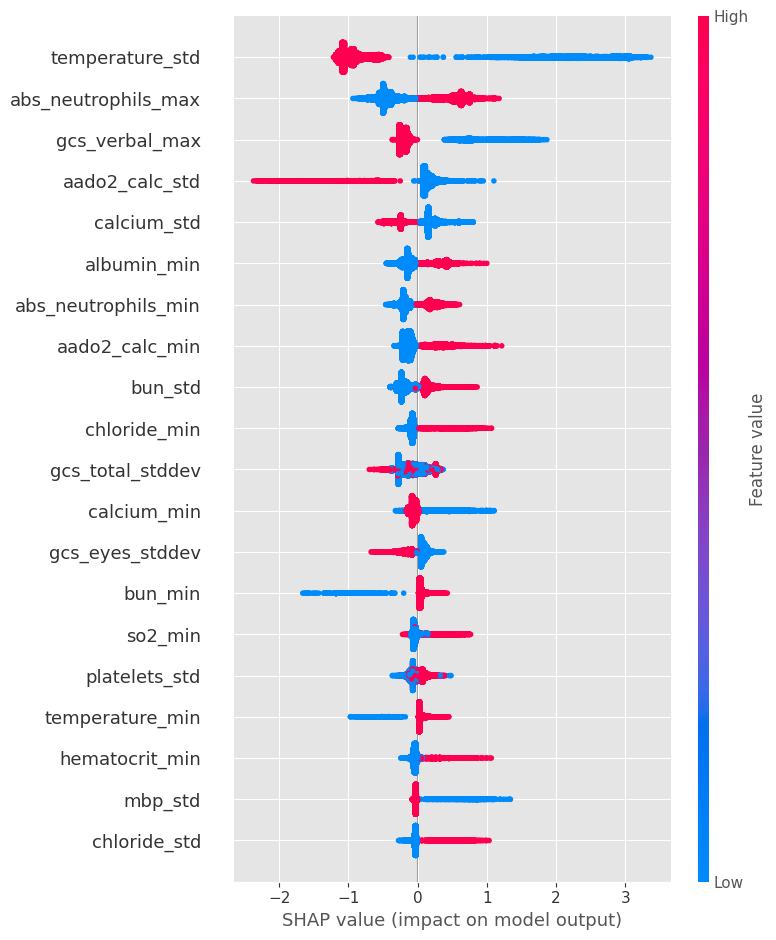

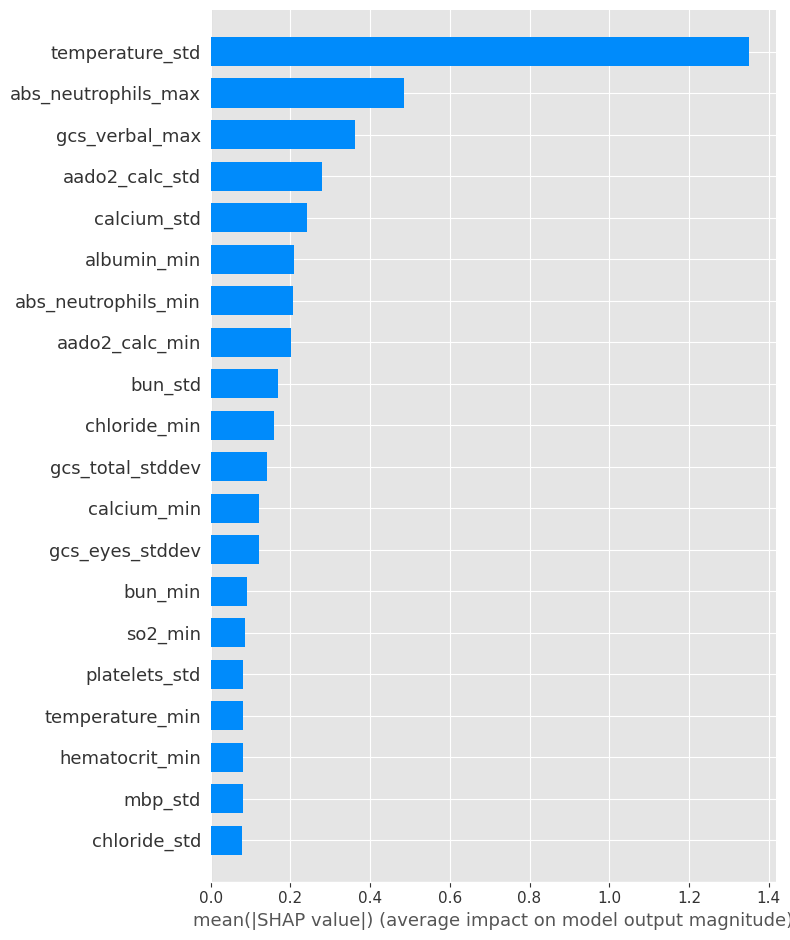

In [40]:
# XGBoost provides some built-in functions to plot feature importance
# We'll ignore those for now and use the shap library instead, anyway here's how to use the built-in functions:
# Gain: Improvement in accuracy resulting from a split according to this feature
# xgb.plot_importance(model, importance_type="gain", show_values=True, max_num_features=20)
# Weight: Number of times this feature occurs in the trees
# xgb.plot_importance(model, importance_type="weight", show_values=True, max_num_features=20)
# Cover: Number of times this feature occurs in the trees weighted by the number of training data points
# xgb.plot_importance(model, importance_type="cover", show_values=True, max_num_features=20)

# Let's look at the feature importance for the best estimator found by grid search (shap values)
import shap
# Initialize javascript visualization
shap.initjs()

# Create a TreeExplainer object using the best estimator
model = grid_search.best_estimator_
explainer = shap.TreeExplainer(model)
# Calculate shap values for the test set
shap_values = explainer.shap_values(X_test)

# Plot the shap values for the test set, only show the 20 most important features
shap.summary_plot(shap_values, X_test, max_display=20)
# Plot the shap values for the test set as a bar chart, only show the 20 most important features
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=20)
# Some quick notes on interpretability:
# Color encodes the feature value, red means high feature value (aka 1, variable present), blue means low feature value (aka 0, variable absent)
# The x-axis encodes the impact on the model output, i.e. the prediction, left means negative impact, right means positive impact

In [42]:
# Which of the 20 most important features are also in the top 20 features by correlation and the top 20 features by difference in null value percentages?

# Get the names of the 20 most important features by shap values
top_20_by_shap = X_test.columns[np.argsort(np.abs(shap_values).mean(0))][-20:].values
# Get the names of the 20 most important features by correlation
top_20_by_corr = abs(corr).T["sepsis"].sort_values(ascending=False).head(20).index.values
# Get the names of the 20 most important features by difference in null value percentages
top_20_by_diff = null_counts_sepsis.sort_values(by="diff", ascending=False).head(20).index.values

# Print set of features that are in all top 20 sets
print("Features in both top 20 sets: ", set(top_20_by_shap).intersection(set(top_20_by_corr)).intersection(set(top_20_by_diff)))

# Features in both top 20 sets:  {'gcs_eyes_stddev', 'abs_neutrophils_max', 'gcs_total_stddev', 'abs_neutrophils_min', 'temperature_std'}

Features in both top 20 sets:  {'gcs_eyes_stddev', 'abs_neutrophils_max', 'gcs_total_stddev', 'abs_neutrophils_min', 'temperature_std'}
